In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

In [2]:
palmdb_clu_tsv_1 = "/home/laura/projects/virus-watch-data/virus_ref/mmseqs_covmode_1/palmdb_DB_clu.tsv"
tax_tsv = "/home/laura/projects/virus-watch-data/virus_ref/u_tax.tsv"

### Load original taxonomies (pre-clustering):

In [3]:
# Load original taxonomies 
df_tax = pd.read_csv(tax_tsv, sep="\t")
df_tax = df_tax.set_index("Label")

# df_tax = df_tax.replace(".", np.nan)
# df_tax = df_tax.dropna(axis=0)

df_tax

,phylum,class,order,family,genus,species
Label,,,,,,
u9,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,West Nile virus
u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus
u6,Negarnaviricota,Insthoviricetes,Articulavirales,Orthomyxoviridae,Betainfluenzavirus,Influenza B virus
u13,Negarnaviricota,Monjiviricetes,Mononegavirales,Rhabdoviridae,Lyssavirus,Rabies lyssavirus
u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
...,...,...,...,...,...,...
u296621,Lenarviricota,Allassoviricetes,Levivirales,.,.,.
u296608,.,.,.,.,.,.
u296622,Lenarviricota,Howeltoviricetes,Cryppavirales,.,.,.


### Load cluster members returned by mmseqs2:

In [4]:
df_clu_1 = pd.read_csv(palmdb_clu_tsv_1, sep="\t", header=None)
# Rename columns
df_clu_1.columns = ["representative", "member"]

In [5]:
codes, uniques = df_clu_1["representative"].factorize()
df_clu_1["cluster"] = codes
df_clu_1

,representative,member,cluster
0,u114534,u114534,0
1,u114534,u107580,0
2,u114534,u229887,0
3,u114534,u227267,0
4,u114534,u275583,0
...,...,...,...
296618,u223919,u121350,6514
296619,u206643,u206643,6515
296620,u206931,u206931,6516
296621,u214451,u214451,6517


___

### Code build:

In [6]:
# Change order of IDs so IDs that are clustered together appear in succession
df_tax_pivoted = df_tax_pivoted.reindex(df_clu_1["member"].values)

In [ ]:
df_tax_pivoted = df_tax_pivoted.reset_index()

df_tax_pivoted = df_tax_pivoted.merge(
    df_clu_1,
    left_on = "Label", 
    right_on = "member",
    how = "outer"
)

df_tax_pivoted = df_tax_pivoted.drop(["representative", "member"], axis=1)
df_tax_pivoted

In [ ]:
df_tax_pivoted = df_tax_pivoted.set_index(["cluster", "Label"])
df_tax_pivoted

In [ ]:
df_tax_pivoted = df_tax_pivoted.sort_values(list(df_tax_pivoted.columns.values), ascending=False)

In [ ]:
df_tax_pivoted = df_tax_pivoted.drop(["."], axis=1)
df_tax_pivoted = df_tax_pivoted.loc[~(df_tax_pivoted==0).all(axis=1)]

### Plot:

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
fontsize = 12

clusters = df_tax_pivoted.index.get_level_values(0).values
cluster_colors = [plt.cm.Spectral(color_idx) for color_idx in clusters]

x = ["∎"] * len(df_tax_pivoted)
y = df_tax_pivoted.columns
values = df_tax_pivoted.values.T

im = ax.imshow(values, cmap="inferno", vmin=0, vmax=1, aspect="auto")

# Add tick labels
ax.set_yticks(np.arange(len(y)), labels=y)
ax.set_xticks(np.arange(len(x)), labels=x)
for xtick, color in zip(ax.get_xticklabels()[:500], cluster_colors[:500]):
    xtick.set_color(color)

ax.set_title(f"Clustered sequences by virus {group_by}", fontsize=fontsize+2)

plt.savefig(f"figures/3.3_{group_by}_seqclusters_heatmaps.png", dpi=300, bbox_inches="tight")
# plt.savefig(f"figures/3.3_{group_by}_seqclusters_heatmaps.svg", dpi=300, bbox_inches="tight")

fig.tight_layout()
fig.show()

___

### Generate heatmaps for each taxnomy level:

Plotting phylum...
Plotting class...
Plotting order...
Plotting family...


<timed exec>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Plotting genus...
Plotting species...
CPU times: user 4min 28s, sys: 59.4 s, total: 5min 27s
Wall time: 5min 29s


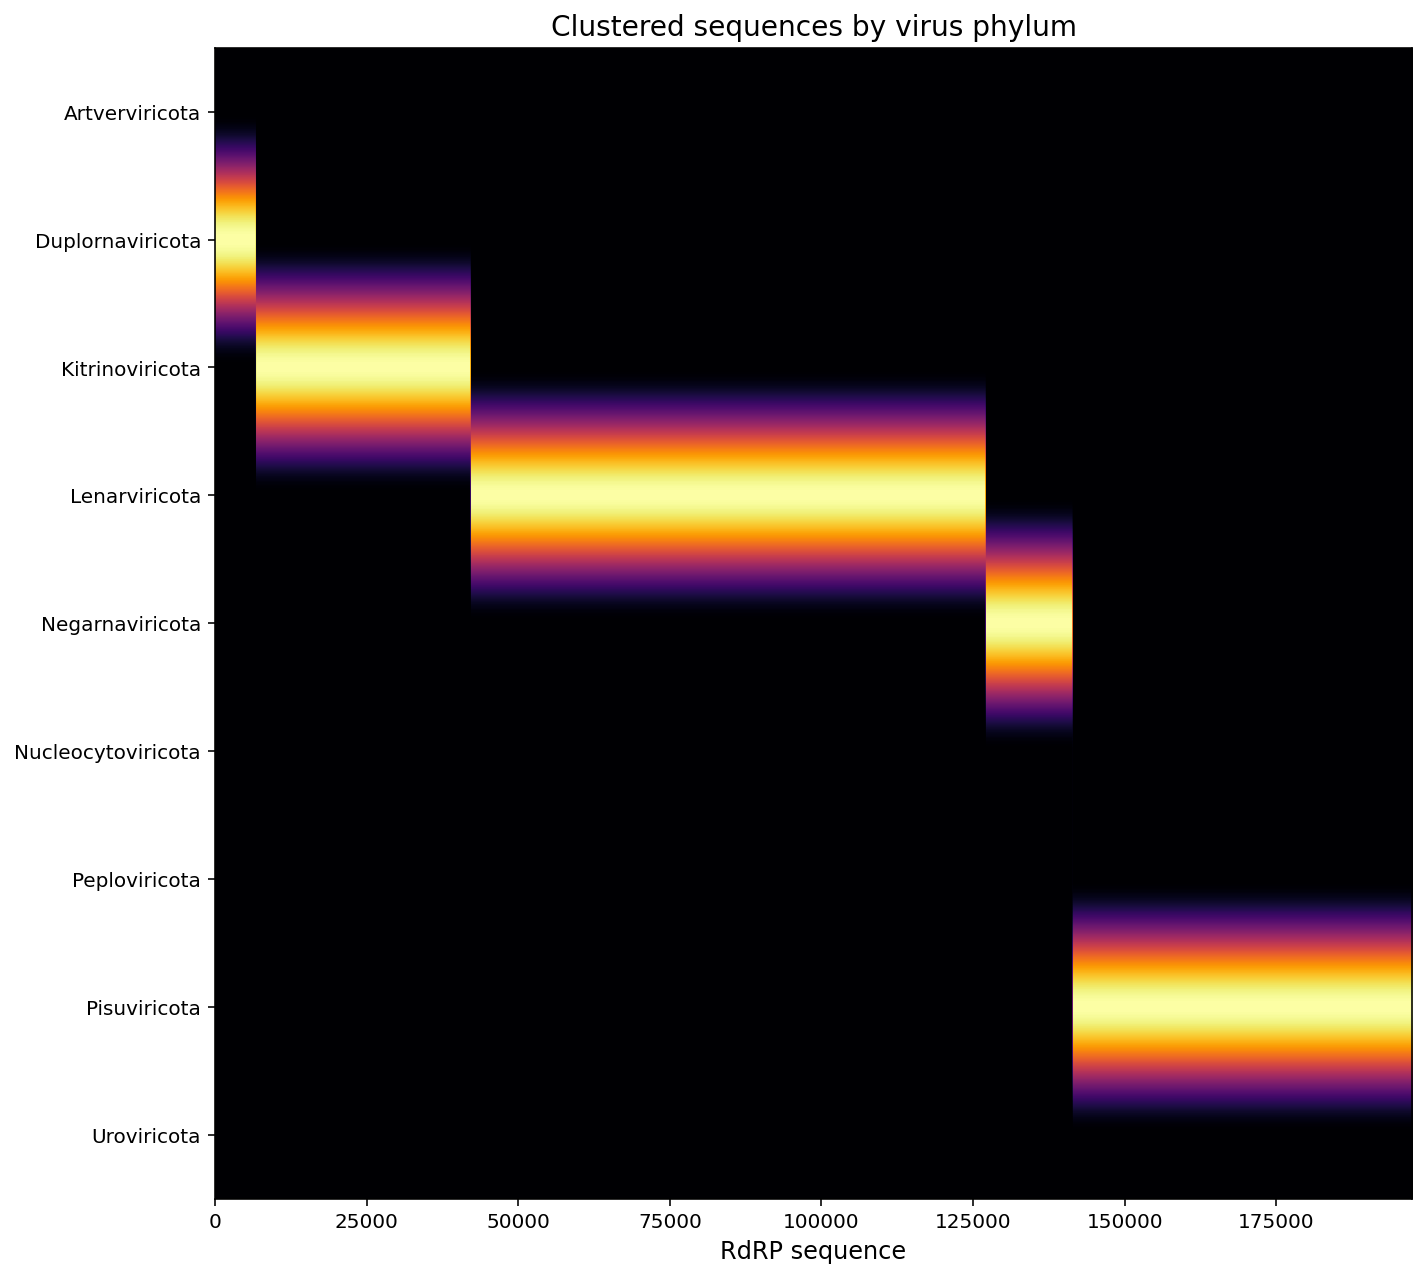

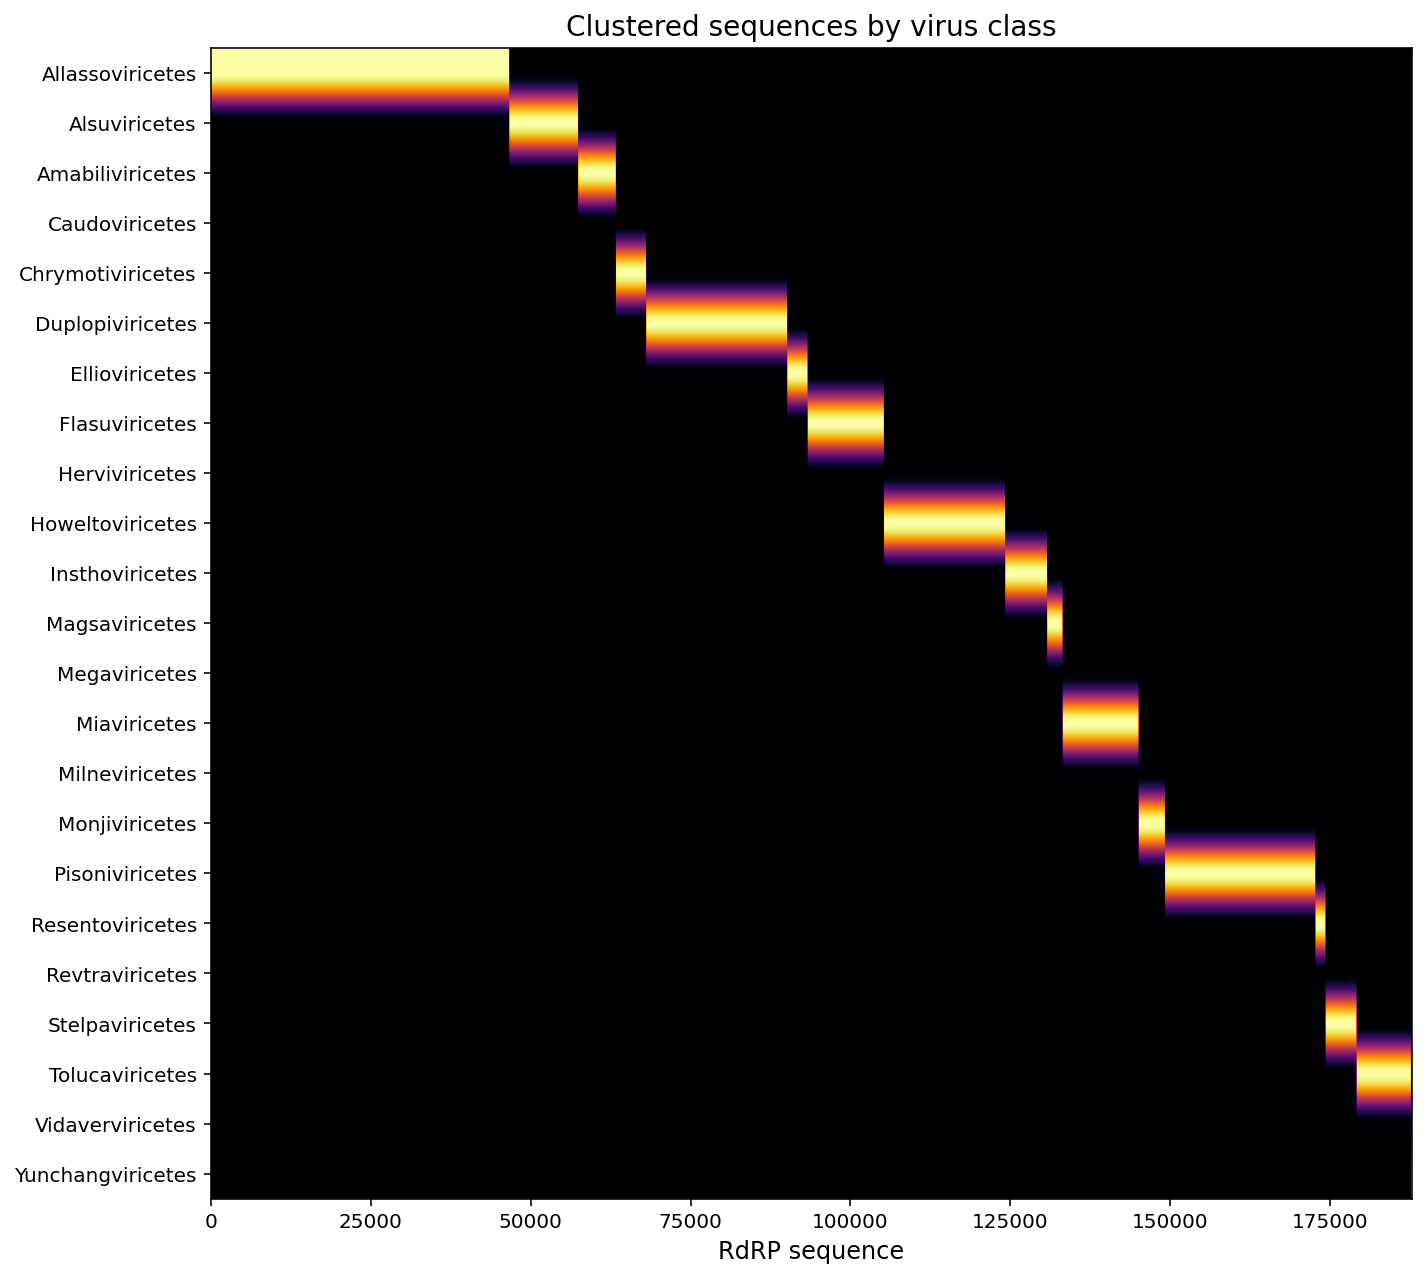

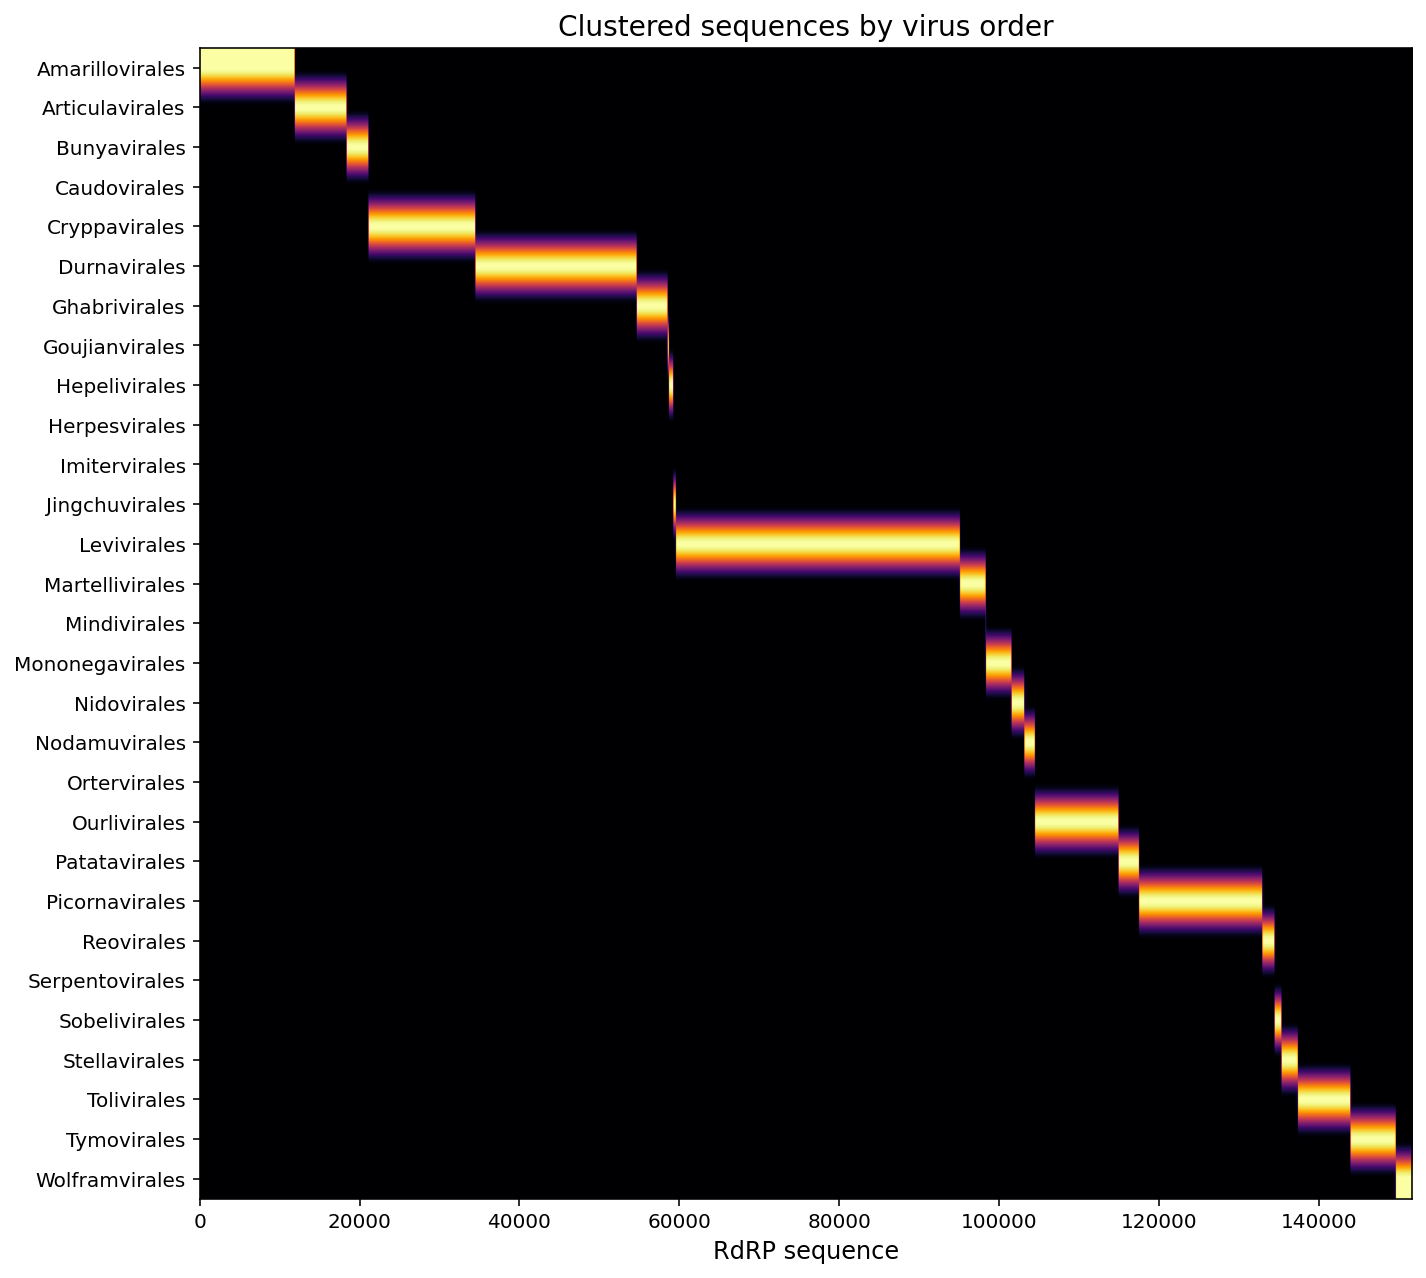

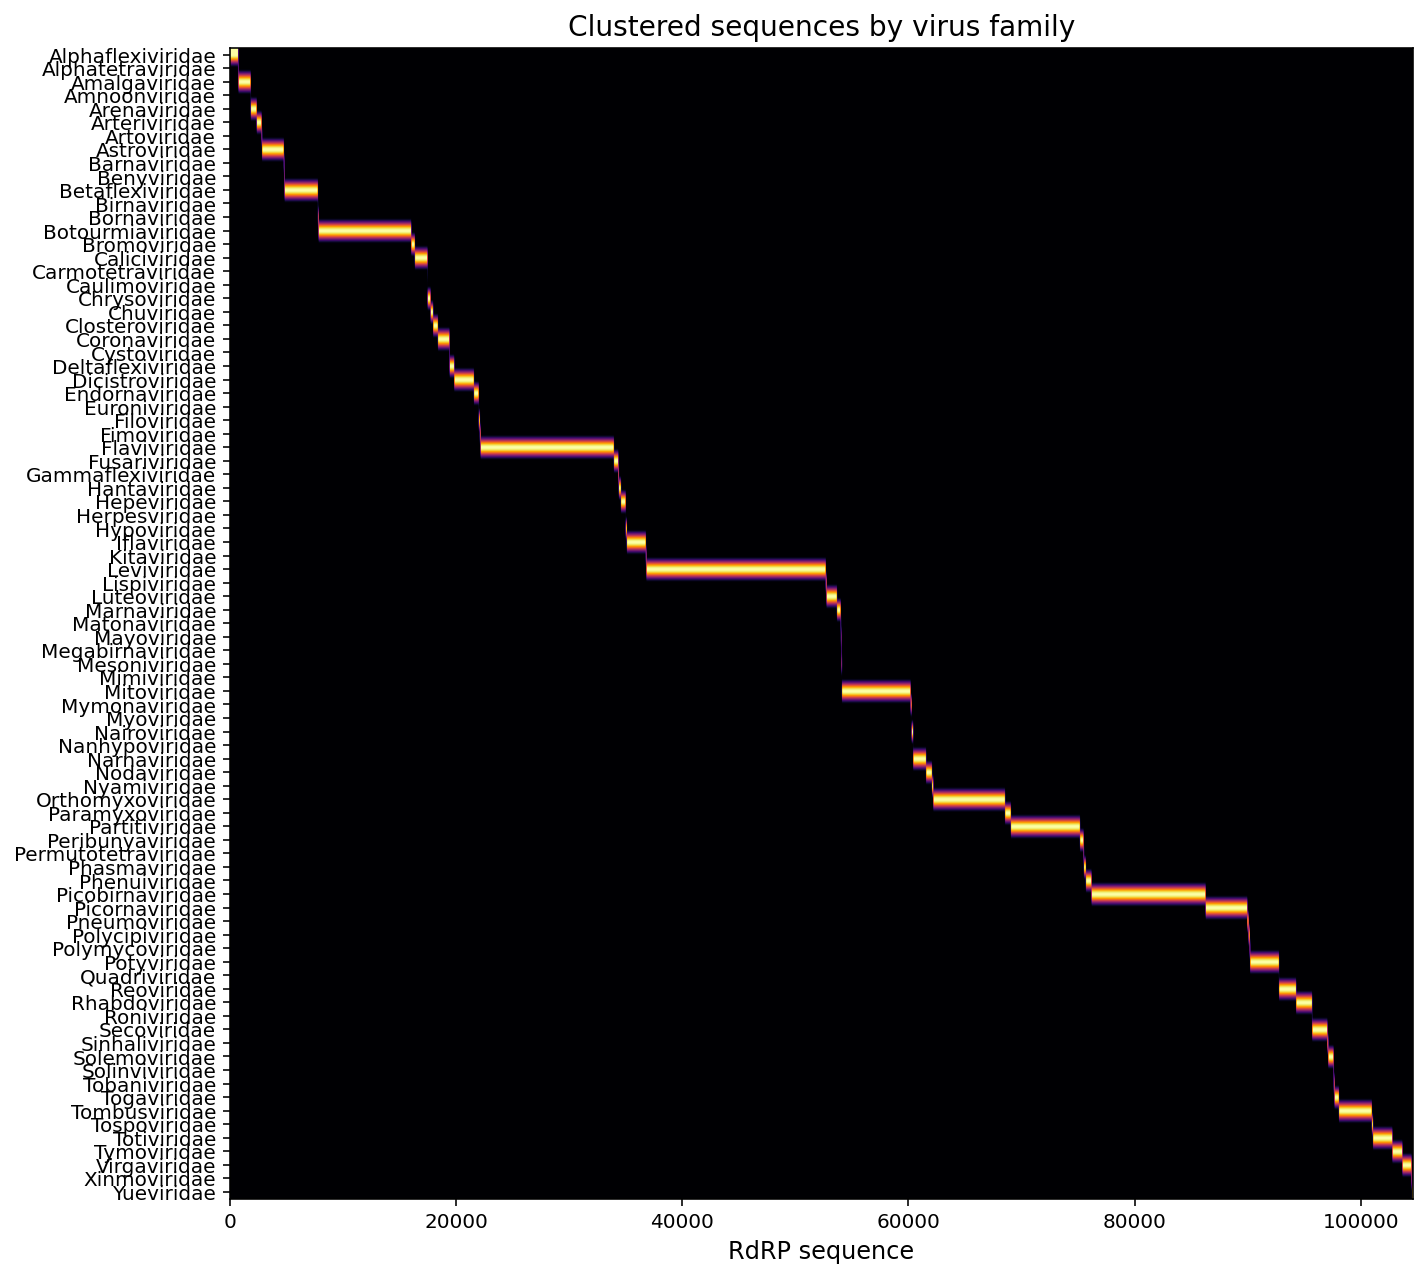

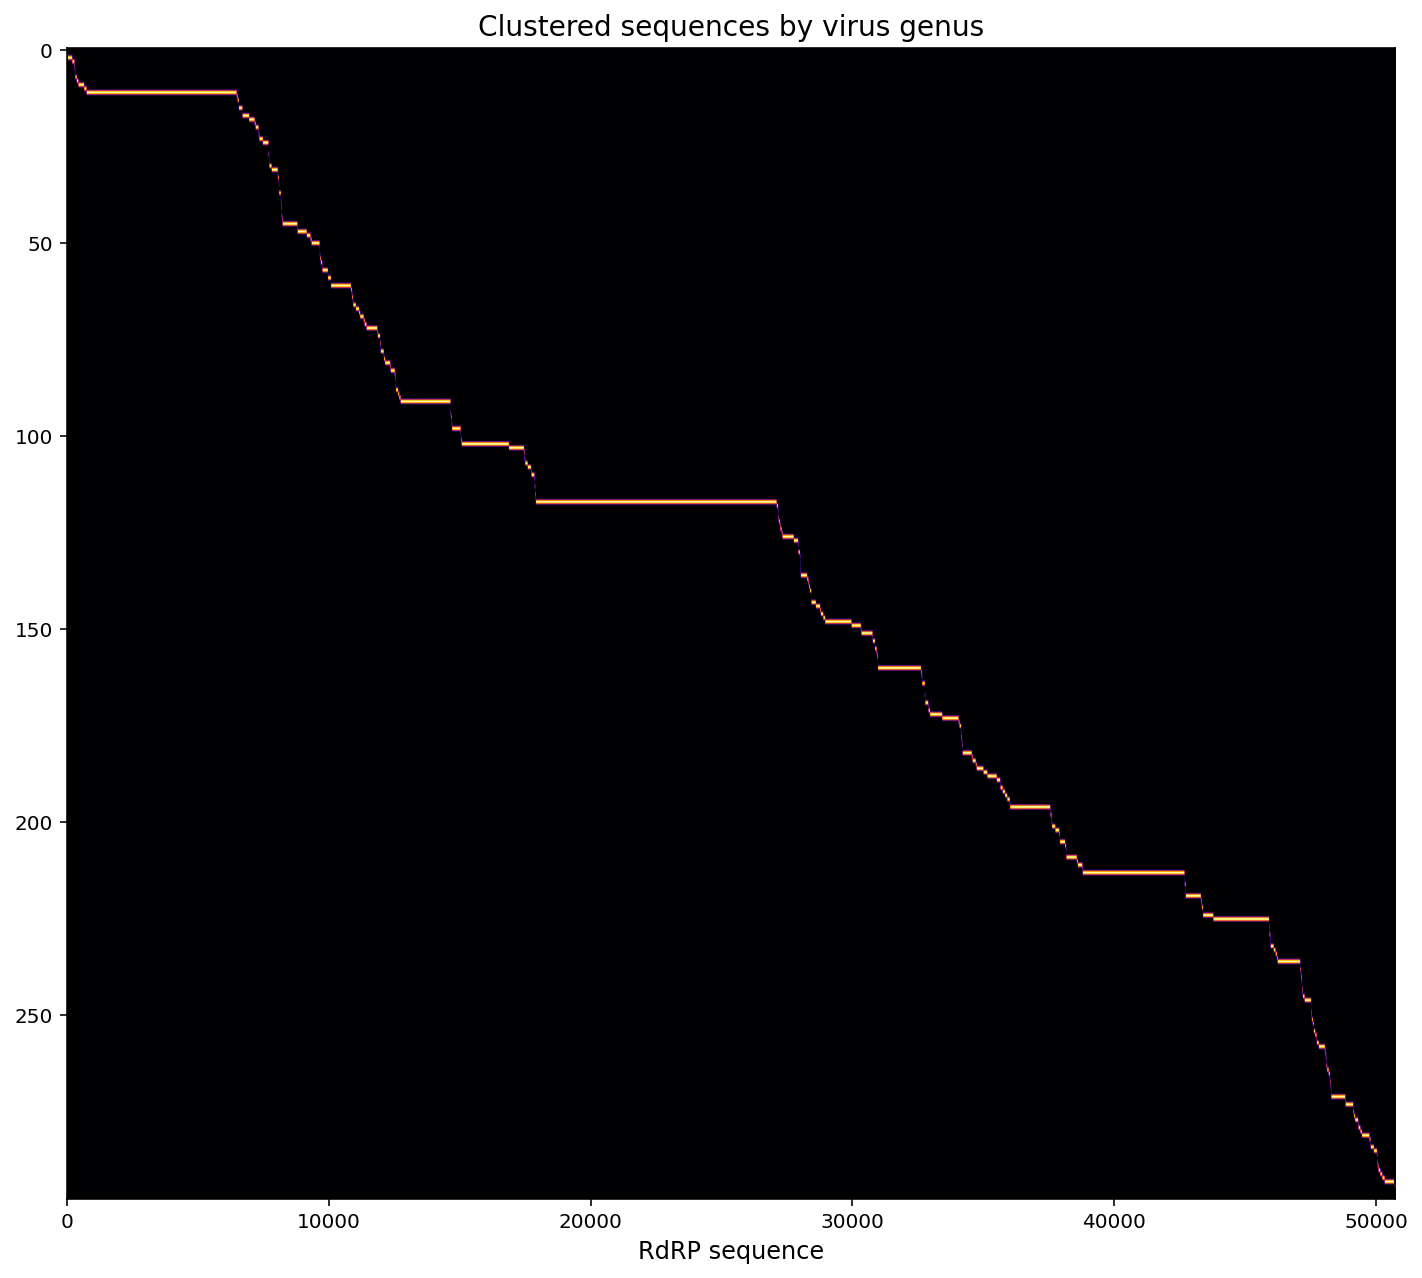

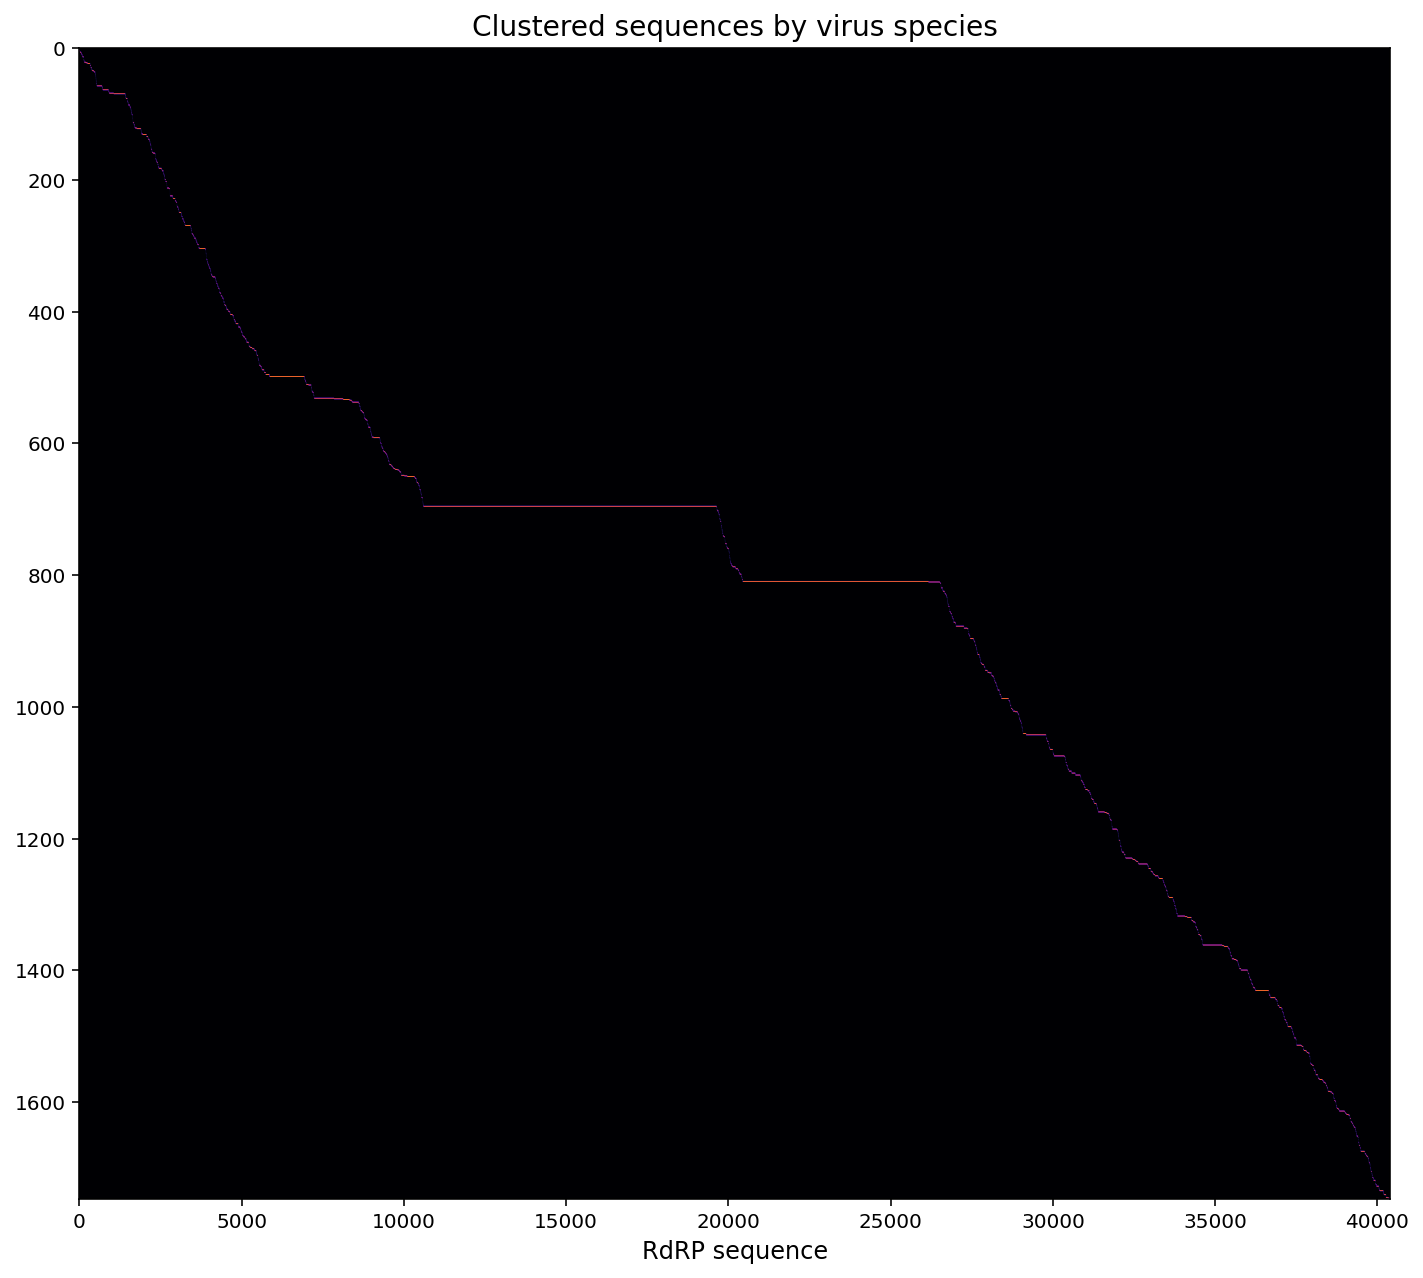

In [38]:
%%time
fontsize = 12

for i, group_by in enumerate(df_tax.columns.values):
    # Create a copy of df_tax keeping only the index
    df_tax_pivoted = pd.DataFrame(df_tax.reset_index()["Label"])
    df_tax_pivoted = df_tax_pivoted.set_index("Label")
    
    # Convert to boolean dataframe by grouping
    for group in np.unique(df_tax[f"{group_by}"].values):
        df_tax_pivoted[group] = pd.DataFrame(df_tax[f"{group_by}"] == group)[f"{group_by}"].values.astype(int)
        
    # Change order of IDs so IDs that are clustered together appear in succession
    df_tax_pivoted = df_tax_pivoted.reindex(df_clu_1["member"].values)
    
    # Add cluster labels
    df_tax_pivoted = df_tax_pivoted.reset_index()
    df_tax_pivoted = df_tax_pivoted.merge(
        df_clu_1,
        left_on = "Label", 
        right_on = "member",
        how = "outer"
    )
    df_tax_pivoted = df_tax_pivoted.drop(["representative", "member"], axis=1)
    df_tax_pivoted = df_tax_pivoted.set_index(["cluster", "Label"])
    
    # Sort values
    df_tax_pivoted = df_tax_pivoted.sort_values(list(df_tax_pivoted.columns.values), ascending=False)
    
    # Drop "." and sequences that have no annotation after dropping "."
    df_tax_pivoted = df_tax_pivoted.drop(["."], axis=1)
    df_tax_pivoted = df_tax_pivoted.loc[~(df_tax_pivoted==0).all(axis=1)]
    
    print(f"Plotting {group_by}...")
    
    # Plot and save heatmap
    fig, ax = plt.subplots(figsize = (10, 9))

    # clusters = df_tax_pivoted.index.get_level_values(0).values
    # cluster_colors = [plt.cm.Spectral(color_idx) for color_idx in clusters]

    # x = ["∎"] * len(df_tax_pivoted)
    y = df_tax_pivoted.columns
    values = df_tax_pivoted.values.T

    im = ax.imshow(values, cmap="inferno", vmin=0, vmax=1, aspect="auto")

    # Add tick labels
    if group_by != "genus" and group_by != "species":
        ax.set_yticks(np.arange(len(y)), labels=y)
    # ax.set_xticks(np.arange(len(x)), labels=x)
    # for xtick, color in zip(ax.get_xticklabels(), cluster_colors):
    #     xtick.set_color(color)

    # # Add lines to delienate clusters
    # for i, cluster_end in enumerate(df_tax_pivoted.reset_index().groupby("cluster", sort=False).count()["Label"].values):
    #     if i == 0:
    #         counter = cluster_end
    #         ax.axvline(counter, color="white", lw=0.1)
    #     else:
    #         counter += cluster_end
    #         ax.axvline(counter, color="white", lw=0.1)

    ax.set_xlabel("RdRP sequence", fontsize=fontsize)
    ax.set_title(f"Clustered sequences by virus {group_by}", fontsize=fontsize+2)

    plt.savefig(f"figures/3.3_{group_by}_seqclusters_heatmaps.png", dpi=300, bbox_inches="tight")
    # plt.savefig(f"figures/3.3_{group_by}_seqclusters_heatmaps.svg", dpi=300, bbox_inches="tight")

    fig.tight_layout()
    fig.show()

___